In [1]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(4372456113935194413)
from torch.distributions import Normal



[4372456113935194413]

In [ ]:
# pi = Variable(torch.FloatTensor([math.pi]))
# def normal(x, mu, sigma_sq):
#     a = (-1*(Variable(x)-mu).pow(2)/(2*sigma_sq)).exp()
#     b = 1/(2*sigma_sq*pi.expand_as(sigma_sq)).sqrt()
#     return a*b


# class Policy(nn.Module):
#     def __init__(self, hidden_size, num_inputs, action_space):
#         super(Policy, self).__init__()
#         self.action_space = action_space
#         num_outputs = action_space.shape[0]

    #     self.linear1 = torch.nn.Linear(num_inputs, hidden_size)
    #     self.linear2 = torch.nn.Linear(hidden_size, num_outputs)
    #     self.linear2_ = torch.nn.Linear(hidden_size, num_outputs)
    #     # value network definition
    #     self.value_fc1 = torch.nn.Linear(num_inputs, 32)
    #     self.value_fc2 = torch.nn.Linear(32, 1)


    # def forward(self, inputs):
    #     x = inputs
    #     x = torch.tanh(self.linear1(x))
    #     mu = self.linear2(x)
    #     sigma_sq = F.softplus(self.linear2_(x))
    #     x2 = inputs
    #     # x2 = F.elu(self.value_fc1(x2))
    #     state_value = self.value_fc2(x2)
    #     # return mu, sigma_sq
    #     return mu, sigma_sq, state_value
    # def select_action(self, inputs):
    #   mu, sigma_sq, state_value = self.forward(inputs)
    #   # mu, sigma_sq = self.model(Variable(state).cuda())
    #   # sigma_sq = F.softplus(sigma_sq)

      
    #   # calculate the probability
    #   eps = torch.randn(mu.size())
    #     # calculate the probability
    #   action = Normal(mu,sigma_sq).sample()
    #   action = torch.clamp(action,-1,1)
    #   prob   = normal(action, mu, sigma_sq)

    #   log_prob = prob.log()
    #   return action, log_prob, state_value
      # return action, log_prob, entropy

In [2]:
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_size):
        super(ActorCritic, self).__init__()
        # self.action_space = action_space
        # num_outputs = action_space.shape[0]

        self.fc = torch.nn.Linear(num_inputs, hidden_size)
        self.mu = torch.nn.Linear(hidden_size, num_outputs)
        self.sigma = torch.nn.Linear(hidden_size, num_outputs)
        # value network definition
        self.value = torch.nn.Linear(hidden_size, 1)
        self.distribution = torch.distributions.Normal
    def forward(self, x):
        x = F.relu(self.fc(x))
        mu = 2*torch.tanh(self.mu(x))
        sigma = F.softplus(self.sigma(x))+1e-5
        dist = self.distribution(mu.view(1, ).data, sigma.view(1, ))
        state_value = self.value(x)
        # return mu, sigma_sq
        return dist, state_value
        # return dist


In [3]:
class Policyestimator():
  def __init__(self, num_state,num_action,hidden_size=50,lr=1e-4):
    self.model = ActorCritic(num_state,num_action,hidden_size)
    self.optimizer = torch.optim.Adam(self.model.parameters(),lr)
  def predict(self,state):
    self.model.training = False
    return self.model(torch.Tensor(state))
  def get_action(self,state):
    dist,state_value = self.predict(state)
    action = dist.sample().numpy()
    log_prob = dist.log_prob(action[0])
    return action, log_prob, state_value
  def update(self, returns, log_probs,state_values):
    p_losses=[]
    v_losses=[]
    policy_loss=0
    value_loss=0
    for a_log_prob, state_value, R in zip(log_probs, state_values, returns):
      p_losses.append(-1 * a_log_prob * (R -state_value))
      v_losses.append(torch.nn.functional.mse_loss(state_value, torch.tensor([R]), reduction='mean'))
    

    policy_loss = torch.stack(p_losses).sum()
    value_loss =  torch.stack(v_losses).sum()
    loss = policy_loss + value_loss
    # loss = policy_loss
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

In [4]:
def scale_state(state):
  scaled = scaler.transform([state])
  return scaled[0]

In [5]:
def actor_critic(env,Policy_estimator,num_episodes,gamma=1):
  for episode in range (num_episodes):
    log_probs =[]
    rewards = []
    state_values =[]
    state = env.reset()
    while True:
      state = scale_state(state)
      action, log_prob, state_value = Policy_estimator.get_action(state)
      action = action.clip(env.action_space.low[0],env.action_space.high[0])
      next_state, reward, is_done, _ = env.step(action)
      total_reward_episode[episode]+=reward
      log_probs.append(log_prob)
      state_values.append(state_value)
      rewards.append(reward)
      if is_done:
        returns = []
        Gt = 0
        pw = 0
        for reward in rewards[::-1]:
          Gt += gamma**pw*reward
          pw += 1
          returns.append(Gt)
        returns = returns[::-1]
        returns = torch.tensor(returns)
        returns = (returns-returns.mean())/(returns.std()+1e-9)
        Policy_estimator.update(returns, log_probs,state_values)
        print('Episode:{},total reward:{}'.format(episode, total_reward_episode[episode]))
        
        break
      state = next_state

In [6]:
import sklearn.preprocessing
import numpy as np
state_space_samples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(state_space_samples)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [ ]:
env = gym.make("MountainCarContinuous-v0")
env.seed(4372456113935194413)

In [7]:
policy = Policyestimator(env.observation_space.shape[0], 1, 128, 0.0003)
policy

In [8]:
num_episode = 200
gamma =0.9
total_reward_episode = [0] * num_episode
actor_critic(env, policy, num_episode, gamma)

Episode:0,total reward:-46.54430061392804
Episode:1,total reward:-47.029960187453334
Episode:2,total reward:76.45330016603187
Episode:3,total reward:-46.87032996206048
Episode:4,total reward:-45.46205850987077
Episode:5,total reward:74.23744427851852
Episode:6,total reward:-44.27752802801324
Episode:7,total reward:-45.88671084926548
Episode:8,total reward:-45.6751491447182
Episode:9,total reward:64.01634667874174
Episode:10,total reward:-45.23666621825414
Episode:11,total reward:-46.59410551692348
Episode:12,total reward:64.07247129092096
Episode:13,total reward:-44.54010712188526
Episode:14,total reward:-44.6790815999305
Episode:15,total reward:-47.03308589355439
Episode:16,total reward:-44.047983771337066
Episode:17,total reward:58.020436880951245
Episode:18,total reward:-43.23356011708446
Episode:19,total reward:-47.152068676509245
Episode:20,total reward:70.2297333313044
Episode:21,total reward:-45.854000163685676
Episode:22,total reward:74.98953663269853
Episode:23,total reward:59

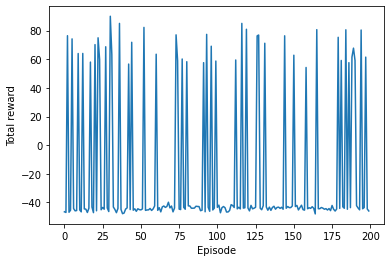

In [9]:
import matplotlib.pyplot as plt
plt.plot(total_reward_episode)
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

In [10]:
[0]

[0]

In [11]:
total_reward_episode


[-46.54430061392804,
 -47.029960187453334,
 76.45330016603187,
 -46.87032996206048,
 -45.46205850987077,
 74.23744427851852,
 -44.27752802801324,
 -45.88671084926548,
 -45.6751491447182,
 64.01634667874174,
 -45.23666621825414,
 -46.59410551692348,
 64.07247129092096,
 -44.54010712188526,
 -44.6790815999305,
 -47.03308589355439,
 -44.047983771337066,
 58.020436880951245,
 -43.23356011708446,
 -47.152068676509245,
 70.2297333313044,
 -45.854000163685676,
 74.98953663269853,
 59.81914883126113,
 -45.132888876601626,
 -43.514359663069634,
 -44.7487836111394,
 68.73126877416772,
 -43.858054129063014,
 -46.379355783328144,
 90.05062087557656,
 63.318760822265226,
 -43.21144069931054,
 -44.92191600834058,
 -47.169386578389314,
 -44.21666853774627,
 85.05464607928958,
 -44.93195057285233,
 -47.8798955319535,
 -47.439939990207385,
 -44.68167340006782,
 -43.82389534865478,
 56.644847229899405,
 -45.014008906601276,
 71.8609007352818,
 -45.44020911613295,
 -44.47573999035536,
 -46.22518673693952